In [1]:
import sys,os
sys.path.insert(0, os.path.abspath(".."))

In [ ]:
import  json
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from src import loading_data as ld

# -------------------------------------------------------------------
# Load host-density index mapping from JSON
# -------------------------------------------------------------------
with open("../dataset/labels/2dmd_host_density.json", "r") as file:
    index_dict = json.load(file)

# List of host–density pairs to evaluate separately
pair_host_density = [
    ("all", "combine"),
    ("P", "high"),
    ("GaSe", "high"),
    ("InSe", "high"),
    ("MoS2", "high"),
    ("WSe2", "high"),
    ("BN", "high"),
    ("MoS2", "low"),
    ("WSe2", "low"),
]

# -------------------------------------------------------------------
# Helper function: filter DataFrame rows by host–density subset
# -------------------------------------------------------------------
def filt_host(df, host, density, index_dict=index_dict):
    """Filter DataFrame rows by given host and density using index_dict."""
    host_density_index = index_dict[host][density]
    host_df_index = df.index.intersection(host_density_index)
    return df.loc[host_df_index, :]


# -------------------------------------------------------------------
# Load global configs
# -------------------------------------------------------------------
configs = ld.load_config_file("../configs/r4_config_allv2.yaml")
database = configs["database"][0]
dataset = configs["dataset"][0]
targets = configs["target_column"]
feature_sets = configs["feature_set"]

# For now, just take the first target
target = targets[0]


# -------------------------------------------------------------------
# Class for host–density specific predictions
# -------------------------------------------------------------------
class SepHostPrediction:
    def __init__(self, target, database="2dmd", dataset="all_density", feature_sets=None):
        """
        Manage host-density specific evaluation for a given target property.
        
        Args:
            target (str): Target property (e.g., 'formation_energy_per_site').
            database (str): Database name.
            dataset (str): Dataset name.
            feature_sets (list): List of feature sets to evaluate.
        """
        self.target = target
        self.database = database
        self.dataset = dataset
        self.feature_sets = feature_sets if feature_sets is not None else configs["feature_set"]

        # Reference results from Kazeev et al. (for comparison in LaTeX tables)
        self.kazeev_results = {
            "formation_energy_per_site": [
                "164$\\pm$5",
                "382$\\pm$30",
                "103$\\pm$4",
                "137$\\pm$5",
                "136$\\pm$5",
                "162$\\pm$6",
                "363$\\pm$17",
                "12.6$\\pm$0.4",
                "16.3$\\pm$0.8",
            ],
            "homo_lumo_gap_min": [
                "117$\\pm$1",
                "174$\\pm$2",
                "173$\\pm$4",
                "155$\\pm$1",
                "71$\\pm$4",
                "106$\\pm$6",
                "208$\\pm$3",
                "26.7$\\pm$0.8",
                "18.3$\\pm$0.6",
            ],
        }

        self.selected_feature_results = None
    # ---------------------------------------------------------------
    # Parity plot
    # ---------------------------------------------------------------
    def parity_plot(y_test,y_pred):
        plt.scatter(y_test,y_pred,alpha=0.6,color='blue')
        plt.plot([min(y_test),max(y_test)],[min(y_pred),max(y_pred)],'--',color='red')
        

    # ---------------------------------------------------------------
    # Compute host-density specific results for all feature sets
    # ---------------------------------------------------------------
    def get_sep_results(self):
        """
        Load trained models and evaluate MAE for each host–density subset.
        
        Returns:
            pd.DataFrame: MAE results indexed by feature_set.
        """
        sep_mae_results = []
        sep_mse_results = []
        sep_r2_results = []


        for feature_set in self.feature_sets:
            # Load trained CatBoost model and test data
            model = ld.load_results(
                "model.pkl",
                self.database,
                feature_set,
                self.dataset,
                self.target,
                "CatBoostRegressor",
                optimize="selected_best_random_100",
                result_dirname="results_2",
            )

            X_test = ld.load_results(
                "X_test.csv",
                self.database,
                feature_set,
                self.dataset,
                self.target,
                "CatBoostRegressor",
                optimize=None,
                result_dirname="results_2",
            )

            y_test = ld.load_results(
                "y_test.csv",
                self.database,
                feature_set,
                self.dataset,
                self.target,
                "CatBoostRegressor",
                optimize=None,
                result_dirname="results_2",
            ).iloc[:, 0]

            sample_weight = ld.load_results(
                "sample_weight.csv",
                self.database,
                feature_set,
                self.dataset,
                self.target,
                "CatBoostRegressor",
                optimize=None,
                result_dirname="results_2",
            ).iloc[:, 0]

            # Dictionary to store results for this feature set
            host_density_mae_dict = {"feature_set": feature_set}
            host_density_mse_dict = {"feature_set": feature_set}
            host_density_r2_dict = {"feature_set": feature_set}

            # Loop over all host-density pairs
            for host, density in pair_host_density:
                if (host == "all") and (density == "combine"):
                    X_test_filt, y_test_filt = X_test, y_test
                else:
                    X_test_filt = filt_host(X_test, host, density, index_dict=index_dict)
                    y_test_filt = y_test.loc[X_test_filt.index]

                # Predict and compute weighted MAE
                y_pred_test = model.predict(X_test_filt)
                test_weight = sample_weight.loc[X_test_filt.index]
                
                # calculate MAE
                test_mae = mean_absolute_error(
                    y_test_filt, y_pred_test, sample_weight=test_weight )
                
                # calculate MSE
                test_mse = mean_squared_error(
                    y_test_filt, y_pred_test,sample_weight=test_weight )
                
                # calculate R2
                test_r2 = r2_score(
                    y_test_filt, y_pred_test,sample_weight=test_weight )
     
 
                # host_density_mae_dict[f"{host}_{density}"] = {'mae':test_mae, 'mse':test_mse, 'r2':test_r2}
                host_density_mae_dict[f"{host}_{density}"] = test_mae
                host_density_mse_dict[f"{host}_{density}"] = test_mse
                host_density_r2_dict[f"{host}_{density}"] = test_r2

            sep_mae_results.append(host_density_mae_dict)
            sep_mse_results.append(host_density_mse_dict)
            sep_r2_results.append(host_density_r2_dict)

        sep_mae_results_df = pd.DataFrame(sep_mae_results).set_index("feature_set")
        sep_mse_results_df = pd.DataFrame(sep_mse_results).set_index("feature_set")
        sep_r2_results_df = pd.DataFrame(sep_r2_results).set_index("feature_set")
        return sep_mae_results_df, sep_mse_results_df, sep_r2_results_df

    # ---------------------------------------------------------------
    # Filter and format results for selected feature sets
    # ---------------------------------------------------------------
    def filter_sep_results(self, sep_results_df,scaling=True):
        """
        Select a subset of feature sets, rescale MAE to meV, 
        and prepare DataFrame for LaTeX table.
        """
        feature_sets = [
            "cfid",
            "vpa_divi_chem_hellinger_l1_pristine_alldist_cfid",
            "chem_dist0_cfid",
            "vpa_divi_chem_hellinger_l1_pristine_cfid",
        ]

        # Select relevant rows and scale errors to meV
        if scaling:
            selected_feature_results = (
                sep_results_df.loc[feature_sets, :] * 1000
            ).round(1).T.reset_index()

        else:
            selected_feature_results = (
                sep_results_df.loc[feature_sets, :]
            ).round(2).T.reset_index()
            

        # Extract host and density columns from index
        selected_feature_results["host"] = selected_feature_results["index"].apply(
            lambda x: x.split("_")[0]
        )
        selected_feature_results["density"] = selected_feature_results["index"].apply(
            lambda x: x.split("_")[1]
        )

        # Keep clean column order
        selected_feature_results = selected_feature_results.loc[
            :,
            [
                "host",
                "density",
                "cfid",
                "vpa_divi_chem_hellinger_l1_pristine_alldist_cfid",
                "chem_dist0_cfid",
                "vpa_divi_chem_hellinger_l1_pristine_cfid",
            ],
        ]

        # Rename feature set columns for LaTeX
        rename_dict = {
            "cfid": "Original\\\\ CFID",
            "vpa_divi_chem_hellinger_l1_pristine_alldist_cfid": "PF-Division\\\\ + Hellinger Distances",
            "chem_dist0_cfid": "Original\\\\ CFID$^*$",
            "vpa_divi_chem_hellinger_l1_pristine_cfid": "PF-Division\\\\ + Hellinger Distances$^*$",
        }
        selected_feature_results.rename(columns=rename_dict, inplace=True)

        # Replace host names with LaTeX-friendly formatting
        rename_host_dict = {
            "MoS2": r"\mos2",
            "WSe2": r"\wse2",
        }
        selected_feature_results["host"] = selected_feature_results["host"].replace(
            rename_host_dict
        )

        self.selected_feature_results = selected_feature_results
        return selected_feature_results

    # ---------------------------------------------------------------
    # Add Kazeev et al. results for comparison
    # ---------------------------------------------------------------
    def add_kazeev_results(self, df):
        """
        Append reference results from Kazeev et al. to the DataFrame.
        """
        kz_result = self.kazeev_results[self.target]
        df["previous \\\\ work \cite{kazeev2023sparse}"] = kz_result
        return df


In [3]:
def main(target):
    feature_sets = [
    "cfid",
    "vpa_divi_chem_hellinger_l1_pristine_alldist_cfid",
    "chem_dist0_cfid",
    "vpa_divi_chem_hellinger_l1_pristine_cfid",
        ]
    sephost_obj = SepHostPrediction(target,feature_sets=feature_sets)
    sep_mae_results_df, sep_mse_results_df, sep_r2_results_df = sephost_obj.get_sep_results()
    filt_sep_mae_results = sephost_obj.filter_sep_results(sep_mae_results_df)
    filt_sep_mse_results = sephost_obj.filter_sep_results(sep_mse_results_df)
    filt_sep_r2_results = sephost_obj.filter_sep_results(sep_r2_results_df,scaling=False)
    filt_sep_results_with_kazeev = sephost_obj.add_kazeev_results(filt_sep_mae_results)
    print('========================= MAE =========================')
    display(filt_sep_results_with_kazeev)
    print('========================= MSE =========================')
    display(filt_sep_mse_results)
    print('========================= R2 =========================')
    display(filt_sep_r2_results)
    return filt_sep_results_with_kazeev 


In [4]:

eform_prediction_df=main('formation_energy_per_site')
# eform_prediction_df

========================= MAE =========================


feature_set,host,density,Original\\ CFID,PF-Division\\ + Hellinger Distances,Original\\ CFID$^*$,PF-Division\\ + Hellinger Distances$^*$,previous \\ work \cite{kazeev2023sparse}
0,all,combine,154.6,141.0,126.9,135.7,164$\pm$5
1,P,high,82.3,76.3,81.8,76.2,382$\pm$30
2,GaSe,high,140.5,135.0,108.7,113.6,103$\pm$4
3,InSe,high,131.8,106.1,88.1,88.1,137$\pm$5
4,\mos2,high,170.1,159.1,121.7,177.8,136$\pm$5
5,\wse2,high,260.3,225.6,192.4,223.7,162$\pm$6
6,BN,high,359.1,341.6,356.5,331.4,363$\pm$17
7,\mos2,low,50.9,44.9,33.7,40.0,12.6$\pm$0.4
8,\wse2,low,41.9,39.3,32.4,34.9,16.3$\pm$0.8


========================= MSE =========================


feature_set,host,density,Original\\ CFID,PF-Division\\ + Hellinger Distances,Original\\ CFID$^*$,PF-Division\\ + Hellinger Distances$^*$
0,all,combine,80.0,70.7,66.0,66.5
1,P,high,11.3,9.3,11.3,9.2
2,GaSe,high,45.0,39.3,29.7,32.5
3,InSe,high,28.7,18.9,17.9,16.6
4,\mos2,high,68.4,60.7,35.7,75.3
5,\wse2,high,129.1,103.4,103.5,105.5
6,BN,high,313.7,295.5,297.9,254.1
7,\mos2,low,32.2,27.7,21.7,27.2
8,\wse2,low,11.6,11.0,10.6,11.3


========================= R2 =========================


feature_set,host,density,Original\\ CFID,PF-Division\\ + Hellinger Distances,Original\\ CFID$^*$,PF-Division\\ + Hellinger Distances$^*$
0,all,combine,0.97,0.97,0.97,0.97
1,P,high,0.61,0.68,0.61,0.68
2,GaSe,high,0.81,0.83,0.87,0.86
3,InSe,high,0.83,0.89,0.89,0.90
4,\mos2,high,0.85,0.87,0.92,0.84
5,\wse2,high,0.54,0.63,0.63,0.62
6,BN,high,0.72,0.74,0.74,0.78
7,\mos2,low,0.98,0.98,0.99,0.98
8,\wse2,low,0.99,0.99,0.99,0.99


In [5]:
gap_prediction_df=main('homo_lumo_gap_min')

========================= MAE =========================


feature_set,host,density,Original\\ CFID,PF-Division\\ + Hellinger Distances,Original\\ CFID$^*$,PF-Division\\ + Hellinger Distances$^*$,previous \\ work \cite{kazeev2023sparse}
0,all,combine,112.7,112.0,116.9,117.8,117$\pm$1
1,P,high,152.1,148.1,152.1,145.7,174$\pm$2
2,GaSe,high,173.3,181.7,194.5,195.8,173$\pm$4
3,InSe,high,149.6,146.9,152.7,147.8,155$\pm$1
4,\mos2,high,64.2,60.4,81.0,88.2,71$\pm$4
5,\wse2,high,89.7,84.9,75.6,80.9,106$\pm$6
6,BN,high,193.0,199.0,210.5,213.9,208$\pm$3
7,\mos2,low,43.3,39.9,36.5,37.8,26.7$\pm$0.8
8,\wse2,low,36.5,35.2,32.2,32.7,18.3$\pm$0.6


========================= MSE =========================


feature_set,host,density,Original\\ CFID,PF-Division\\ + Hellinger Distances,Original\\ CFID$^*$,PF-Division\\ + Hellinger Distances$^*$
0,all,combine,32.7,31.7,36.9,35.1
1,P,high,37.3,33.9,37.7,33.6
2,GaSe,high,53.9,58.1,64.4,62.2
3,InSe,high,40.3,39.3,43.4,39.7
4,\mos2,high,7.1,7.2,23.3,22.4
5,\wse2,high,32.3,23.9,24.2,21.4
6,BN,high,74.5,76.8,88.7,88.3
7,\mos2,low,9.0,6.5,6.2,6.2
8,\wse2,low,7.7,7.6,7.5,7.1


========================= R2 =========================


feature_set,host,density,Original\\ CFID,PF-Division\\ + Hellinger Distances,Original\\ CFID$^*$,PF-Division\\ + Hellinger Distances$^*$
0,all,combine,0.85,0.86,0.84,0.84
1,P,high,0.51,0.56,0.51,0.56
2,GaSe,high,0.65,0.63,0.58,0.60
3,InSe,high,0.50,0.51,0.46,0.50
4,\mos2,high,0.94,0.94,0.81,0.82
5,\wse2,high,0.79,0.85,0.84,0.86
6,BN,high,0.27,0.25,0.13,0.14
7,\mos2,low,0.97,0.98,0.98,0.98
8,\wse2,low,0.98,0.98,0.98,0.98


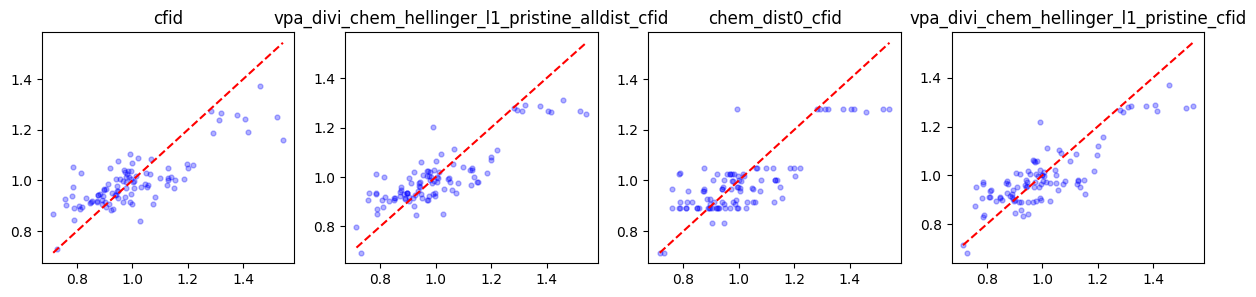

In [59]:
feature_sets = [
    "cfid",
    "vpa_divi_chem_hellinger_l1_pristine_alldist_cfid",
    "chem_dist0_cfid",
    "vpa_divi_chem_hellinger_l1_pristine_cfid",
]
fig,axs = plt.subplots(nrows=1,ncols=4,figsize=(15,3))
i=0
for feature_set in feature_sets:
    # Load trained CatBoost model and test data
    model = ld.load_results(
        "model.pkl",
        '2dmd',
        feature_set,
        'all_density',
        'formation_energy_per_site',
        "CatBoostRegressor",
        optimize="selected_best_random_100",
        result_dirname="results_2",
    )

    X_test = ld.load_results(
        "X_test.csv",
        '2dmd',
        feature_set,
        'all_density',
        'formation_energy_per_site',
        "CatBoostRegressor",
        optimize=None,
        result_dirname="results_2",
    )

    y_test = ld.load_results(
        "y_test.csv",
        '2dmd',
        feature_set,
        'all_density',
        'formation_energy_per_site',
        "CatBoostRegressor",
        optimize=None,
        result_dirname="results_2",
    ).iloc[:, 0]

    sample_weight = ld.load_results(
        "sample_weight.csv",
        '2dmd',
        feature_set,
        'all_density',
        'formation_energy_per_site',
        "CatBoostRegressor",
        optimize=None,
        result_dirname="results_2",
    ).iloc[:, 0]

    # Dictionary to store results for this feature set
    host_density_mae_dict = {"feature_set": feature_set}
    host_density_mse_dict = {"feature_set": feature_set}
    host_density_r2_dict = {"feature_set": feature_set}


    X_test_filt = filt_host(X_test, 'P', 'high', index_dict=index_dict)
    # X_test_filt = X_test
    y_test_filt = y_test.loc[X_test_filt.index]

    # Predict and compute weighted MAE
    y_pred_test = model.predict(X_test_filt)
    test_weight = sample_weight.loc[X_test_filt.index]
    
    axs[i].set_title(feature_set)
    axs[i].scatter(y_test_filt,y_pred_test,color='blue',alpha=0.3,s =12)
    # axs[i].plot([min(y_test_filt),max(y_test_filt)],[min(y_pred_test),max(y_pred_test)],'--',color='green')
    axs[i].plot([min(y_test_filt),max(y_test_filt)],[min(y_test_filt),max(y_test_filt)],'--',color='red')
    # axs[i].plot([min(y_pred_test),max(y_pred_test)],[min(y_pred_test),max(y_pred_test)],'--',color='blue')
    i+=1